# Handwritten Character Recognition with Neural Network

This notebook contains code to build a deep learning model for recognizing handwritten characters, i.e, English alphabets from A-Z and 0-9.
A neural network is modelled and trained over a dataset containing images of alphabets and numbers.

### Required Packages

In [1]:
import warnings
warnings.filterwarnings('ignore')
import os
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout
from tensorflow.keras.optimizers import SGD, Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.utils import to_categorical
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

### Data Fetching

In [2]:
# alphabet dataset
df1 = pd.read_csv("../input/az-handwritten-alphabets-in-csv-format/A_Z Handwritten Data.csv")

# digit dataset
df2 = pd.read_csv("../input/digit-recognizer/train.csv")

# combining both the datasets to get a single data set
df1['0'] = df1['0']+10
df1.columns = df2.columns
frames = [df1, df2]  
df = pd.concat(frames)
df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,10,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,10,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,10,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,10,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,10,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Feature Selections

In [3]:
X = df.drop('label',axis = 1) #feautures
y = df['label'] #target

### Data Splitting

In [4]:
train_x, test_x, train_y, test_y = train_test_split(X, y, test_size = 0.2)

train_x = np.reshape(train_x.values, (train_x.shape[0], 28,28))
test_x = np.reshape(test_x.values, (test_x.shape[0], 28,28))

print("Train data shape: ", train_x.shape)
print("Test data shape: ", test_x.shape)

Train data shape:  (331560, 28, 28)
Test data shape:  (82890, 28, 28)


### Exploratory Data Analysis

In [5]:
# check for missing data
def missing_data(data):
    total = data.isnull().sum().sort_values(ascending = False)
    percent = (data.isnull().sum()/data.isnull().count()*100).sort_values(ascending = False)
    return pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data(df)

,Total,Percent
label,0,0.0
pixel515,0,0.0
pixel517,0,0.0
pixel518,0,0.0
pixel519,0,0.0
...,...,...
pixel263,0,0.0
pixel264,0,0.0
pixel265,0,0.0
pixel266,0,0.0


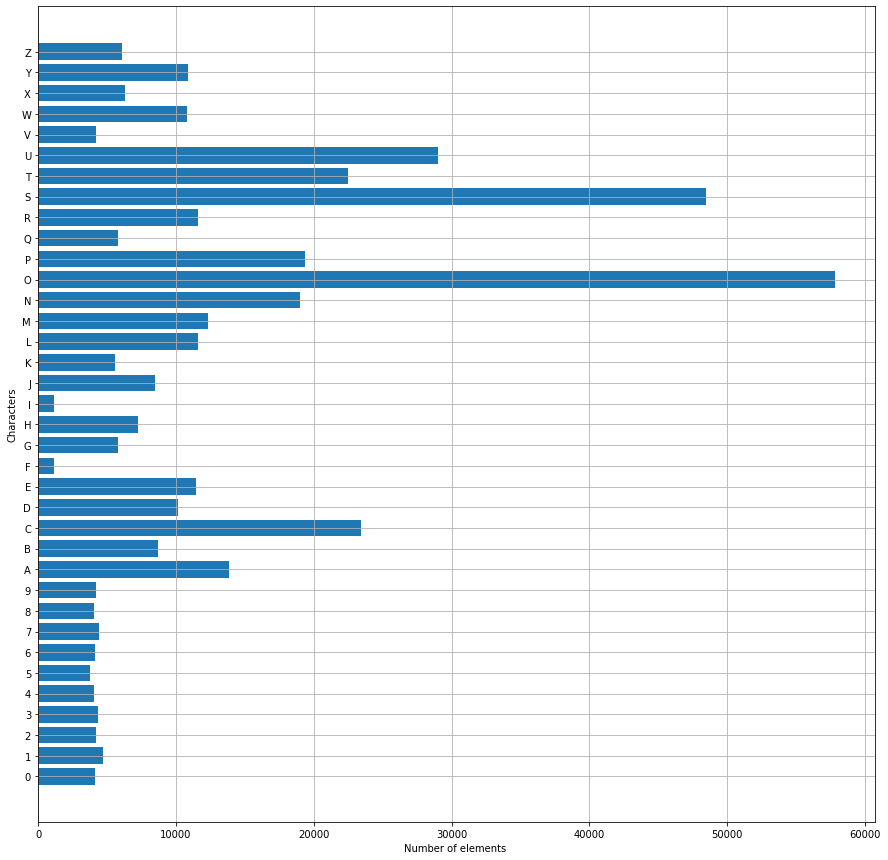

In [6]:
# checking Characters distribution
word_dict = {0:'0',1:'1',2:'2',3:'3',4:'4',5:'5',6:'6',7:'7',8:'8',9:'9',10:'A',11:'B',12:'C',13:'D',14:'E',15:'F',16:'G',17:'H',18:'I',19:'J',20:'K',21:'L',22:'M',23:'N',24:'O',25:'P',26:'Q',27:'R',28:'S',29:'T',30:'U',31:'V',32:'W',33:'X', 34:'Y',35:'Z'}
y_int = np.int0(y)
count = np.zeros(36, dtype='int')
for i in y_int:
    count[i] +=1

alphabets = []
for i in word_dict.values():
    alphabets.append(i)

fig, ax = plt.subplots(1,1, figsize=(15,15))
ax.barh(alphabets, count)

plt.xlabel("Number of elements ")
plt.ylabel("Characters")
plt.grid()
plt.show()

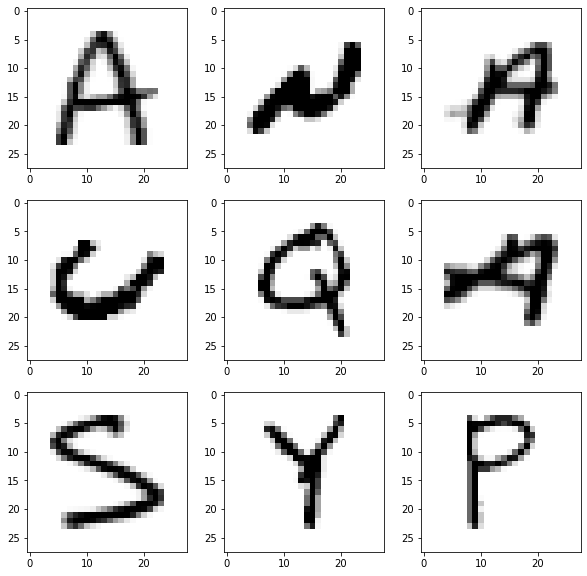

In [7]:
# printing some shuffled samples

shuff = shuffle(train_x[:-100])
shuff = shuff.astype(np.uint8)
fig, ax = plt.subplots(3,3, figsize = (10,10))
axes = ax.flatten()

for i in range(9):
    _, shu = cv2.threshold(shuff[i], 30, 200, cv2.THRESH_BINARY)
    axes[i].imshow(np.reshape(shuff[i], (28,28)), cmap="Greys")
plt.show()

### Data Preprocessing

In [8]:
train_X = train_x.reshape(train_x.shape[0],train_x.shape[1],train_x.shape[2],1)
print("New shape of train data: ", train_X.shape)
test_X = test_x.reshape(test_x.shape[0], test_x.shape[1], test_x.shape[2],1)
print("New shape of train data: ", test_X.shape)

New shape of train data:  (331560, 28, 28, 1)
New shape of train data:  (82890, 28, 28, 1)


In [9]:
train_yOHE = to_categorical(train_y, num_classes = 36, dtype='int')
print("New shape of train labels: ", train_yOHE.shape)
test_yOHE = to_categorical(test_y, num_classes = 36, dtype='int')
print("New shape of test labels: ", test_yOHE.shape)

New shape of train labels:  (331560, 36)
New shape of test labels:  (82890, 36)


### Model

In [10]:
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(28,28,1)))
model.add(MaxPool2D(pool_size=(2, 2), strides=2))

model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding = 'same'))
model.add(MaxPool2D(pool_size=(2, 2), strides=2))

model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding = 'valid'))
model.add(MaxPool2D(pool_size=(2, 2), strides=2))

model.add(Flatten())

model.add(Dense(64,activation ="relu"))
model.add(Dense(128,activation ="relu"))

model.add(Dense(36,activation ="softmax"))

2022-07-31 11:56:01.937408: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [11]:
model.compile(optimizer = Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(train_X, train_yOHE, epochs=5,  validation_data = (test_X,test_yOHE))

2022-07-31 11:56:05.545251: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/5
10362/10362 [==============================] - 208s 20ms/step - loss: 0.2375 - accuracy: 0.9342 - val_loss: 0.1286 - val_accuracy: 0.9633
Epoch 2/5
10362/10362 [==============================] - 209s 20ms/step - loss: 0.1141 - accuracy: 0.9681 - val_loss: 0.1098 - val_accuracy: 0.9711
Epoch 3/5
10362/10362 [==============================] - 203s 20ms/step - loss: 0.0955 - accuracy: 0.9737 - val_loss: 0.1176 - val_accuracy: 0.9694
Epoch 4/5
10362/10362 [==============================] - 206s 20ms/step - loss: 0.0872 - accuracy: 0.9761 - val_loss: 0.1009 - val_accuracy: 0.9722
Epoch 5/5
10362/10362 [==============================] - 201s 19ms/step - loss: 0.0819 - accuracy: 0.9774 - val_loss: 0.0951 - val_accuracy: 0.9751


In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 128)         73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 2, 2, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 512)               0

### Accuracy Metrics

In [13]:
print("The validation accuracy is :", history.history['val_accuracy'][0]*100)
print("The training accuracy is :", history.history['accuracy'][0]*100)
print("The validation loss is :", history.history['val_loss'][0]*100)
print("The training loss is :", history.history['loss'][0]*100)

The validation accuracy is : 96.33007645606995
The training accuracy is : 93.42200756072998
The validation loss is : 12.860813736915588
The training loss is : 23.747697472572327


In [14]:
score = model.evaluate(test_X,test_yOHE, verbose = 0)
print('Test loss: {}%'.format(score[0] * 100))
print('Test score: {}%'.format(score[1] * 100))

print("MLP Error: %.2f%%" % (100 - score[1] * 100))

Test loss: 9.505309909582138%
Test score: 97.5099503993988%
MLP Error: 2.49%


### Learning Curve

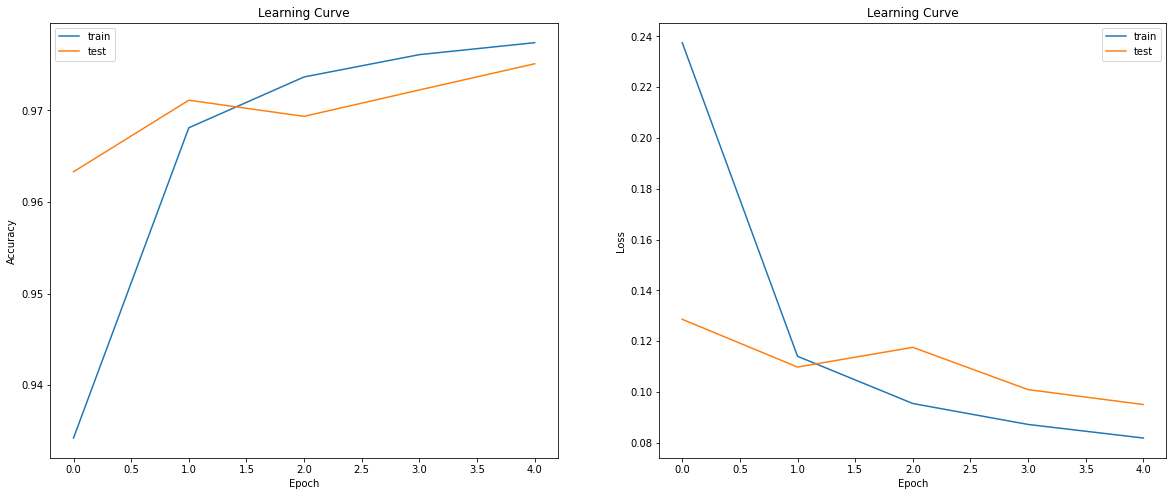

In [15]:
def draw_learning_curve(history, keys=['accuracy', 'loss']):
    plt.figure(figsize=(20,8))
    for i, key in enumerate(keys):
        plt.subplot(1, 2, i + 1)
        sns.lineplot(x = history.epoch, y = history.history[key])
        sns.lineplot(x = history.epoch, y = history.history['val_' + key])
        plt.title('Learning Curve')
        plt.ylabel(key.title())
        plt.xlabel('Epoch')
#         plt.ylim(ylim)
        plt.legend(['train', 'test'], loc='best')
    plt.show()
draw_learning_curve(history)

### Predictions

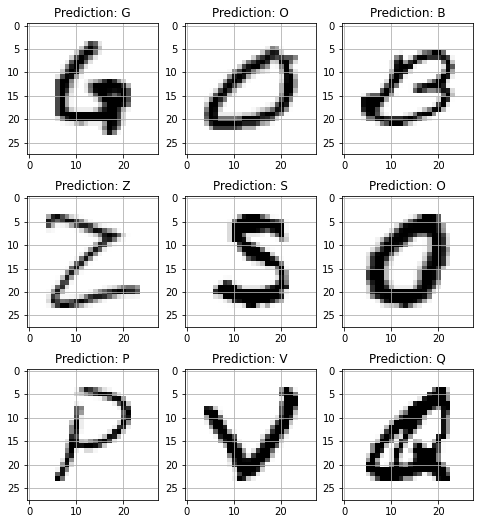

In [16]:
fig, axes = plt.subplots(3,3, figsize=(8,9))
axes = axes.flatten()
for i,ax in enumerate(axes):
    img = np.reshape(test_X[i], (28,28))
    ax.imshow(img, cmap="Greys")
    
    pred = word_dict[np.argmax(test_yOHE[i])]
    ax.set_title("Prediction: "+pred)
    ax.grid()

### Saving Model

In [17]:
model.save(r'model_hand.h5')